# FarmWise: Farmland Segmentation and Size Classification with YOLOv8

**Date**: April 14, 2025

This notebook implements a farm segmentation system using the **YOLOv8** architecture to identify agricultural fields from satellite imagery, calculate their sizes, and classify them for targeted recommendations.

## Project Overview

**Goal**: Create a system that can:
1. Detect and segment farmlands from satellite imagery
2. Calculate the size/area of each identified farm
3. Classify farms by size (small, medium, large)
4. Enable a recommendation system based on farm size classification

**Approach**: **YOLOv8** architecture for instance segmentation, leveraging transfer learning.

## 1. Business Understanding

### 1.1 Problem Statement

Agricultural recommendations are most effective when tailored to the specific context of a farm, with farm size being a crucial factor. Large farms may benefit from different techniques, equipment, and crop selections compared to small ones. This project aims to automatically classify farms by size from satellite imagery to enable targeted recommendations.

### 1.2 Success Criteria

- **Technical Success**: Achieve high accuracy in farmland segmentation (e.g., mAP50-95 > 0.6 for segmentation)
- **Business Success**: Enable accurate size-based classification of farms for targeted recommendations

## 2. Data Acquisition and Understanding

### 2.1 Setup and Environment Preparation

In [ ]:
# Install necessary libraries, including ultralytics for YOLOv8
!pip install torch torchvision matplotlib numpy pillow scikit-learn scikit-image opencv-python roboflow tqdm ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 23.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 23.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take i

In [ ]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import cv2
from skimage import measure
from tqdm.notebook import tqdm
from roboflow import Roboflow
import yaml
import random
from ultralytics import YOLO # Import YOLO

# Set random seeds for reproducibility (less critical for YOLO training but good practice)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check for GPU availability and set up device
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    gpu_indices = list(range(num_gpus))
    for i in gpu_indices:
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    # Create device string for YOLO: '0' for one GPU, '0,1' for two, etc.
    device = ','.join(map(str, gpu_indices)) if num_gpus > 0 else 'cpu'
    print(f"Using device string for YOLO: '{device}'")
else:
    device = 'cpu'
    print("No GPU available, using CPU. Training will be significantly slower.")

# Display CUDA version if available
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Current CUDA device index: {torch.cuda.current_device()}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA Available: True
Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Using device string for YOLO: '0,1'
CUDA Version: 12.1
Current CUDA device index: 0
CUDA Available: True
Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Using device string for YOLO: '0,1'
CUDA Version: 12.1
Current CUDA device index: 0


### 2.2 Data Acquisition from Roboflow

We acquire the dataset in YOLOv8 format, which includes images and corresponding text files with segmentation coordinates.

In [ ]:
# Initialize Roboflow and load dataset
# Note: You will need to provide your Roboflow API key
try:
    rf = Roboflow(api_key="HE9CEH5JxJ3U0vXrQTOy")  # Replace with your actual API key
    project = rf.workspace("sid-mp92l").project("final-detectron-2")
    # Ensure the format is compatible with YOLOv8 segmentation (often 'yolov8' or similar)
    dataset = project.version(1).download("yolov8")
    dataset_location = dataset.location
    data_yaml_path = os.path.join(dataset_location, 'data.yaml')
    print(f"Dataset downloaded to: {dataset_location}")
    print(f"Data YAML path: {data_yaml_path}")
    # Verify data.yaml exists
    if not os.path.exists(data_yaml_path):
        print(f"\nERROR: data.yaml not found at {data_yaml_path}. YOLOv8 training requires this file.")
        # Attempt to find it one level deeper if structure is nested
        potential_yaml = os.path.join(dataset_location, project.name, 'data.yaml')
        if os.path.exists(potential_yaml):
             data_yaml_path = potential_yaml
             print(f"Found data.yaml at nested path: {data_yaml_path}")
        else:
             data_yaml_path = None # Indicate failure
             print("Please check the downloaded dataset structure.")
    else:
        print("data.yaml found successfully.")
except Exception as e:
    print(f"Error during Roboflow download or setup: {e}")
    print("Please ensure your API key is correct and the dataset exists.")
    dataset_location = None
    data_yaml_path = None

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...
Dataset downloaded to: /kaggle/working/Final-Detectron-2-1
Data YAML path: /kaggle/working/Final-Detectron-2-1/data.yaml
data.yaml found successfully.
Dataset downloaded to: /kaggle/working/Final-Detectron-2-1
Data YAML path: /kaggle/working/Final-Detectron-2-1/data.yaml
data.yaml found successfully.


### 2.3 Dataset Exploration

Let's examine the structure of our dataset (downloaded in YOLOv8 format) and visualize some sample images with their annotations.

In [ ]:
# Explore the dataset structure
def explore_directory(path, level=0):
    if not path or not os.path.isdir(path):
        print(f"Cannot explore path: {path}")
        return
    print('  ' * level + f"|-- {os.path.basename(path)}")
    try:
        items = os.listdir(path)
        for i, item in enumerate(items):
            if i >= 10 and len(items) > 15: # Show first 10 and last 5 if many items
                if i == 10:
                     print('  ' * (level + 1) + f"|-- ... ({len(items) - 15} more items) ...")
                elif i < len(items) - 5:
                     continue
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                explore_directory(item_path, level + 1)
            else:
                print('  ' * (level + 1) + f"|-- {item}")
    except Exception as e:
        print(f"Error exploring directory {path}: {e}")

print("Dataset Structure:")
if dataset_location:
    explore_directory(dataset_location)
else:
    print("Dataset location not defined. Cannot explore structure.")

Dataset Structure:
|-- Final-Detectron-2-1
  |-- README.dataset.txt
  |-- data.yaml
  |-- README.roboflow.txt
  |-- valid
    |-- labels.cache
    |-- images
      |-- 0231031302330_png_jpg.rf.62b2b8fa0b82be1117ffbb8c5785f034.jpg
      |-- F_30002205_jpg.rf.36bbc75749fde6361a974f530d0de3e6.jpg
      |-- F_3000333_jpg.rf.2f4946a334dab908127561f17482d8df.jpg
      |-- 023010323221321_png_jpg.rf.a698759471275ca2cf5301748fcddc70.jpg
      |-- F_30002052_jpg.rf.4b31675a76b51f6505f5bfb42a6257c7.jpg
      |-- F_30001091_jpg.rf.52e98dcaed3cba1c45209f162119453c.jpg
      |-- 023132233013112_png_jpg.rf.0cbdb3cf8f6a2ba7e2a5458d9bd3104f.jpg
      |-- Image1324_jpg.rf.8a4ff611822be0c251e612cc4bf3c4cb.jpg
      |-- 02133230310320_png_jpg.rf.be3a43696fe97fe192149229cdb483ea.jpg
      |-- 0320100101232131_png_jpg.rf.ca5c693492830394c62eaf3de305fb6a.jpg
      |-- ... (703 more items) ...
      |-- F_30001099_jpg.rf.23bc7870821d1260e3d8649e460eb4eb.jpg
      |-- h453_jpg.rf.e71dbfeb415ac0cd300ce525d9607


--- Starting Random Sample Visualization (3 samples) ---


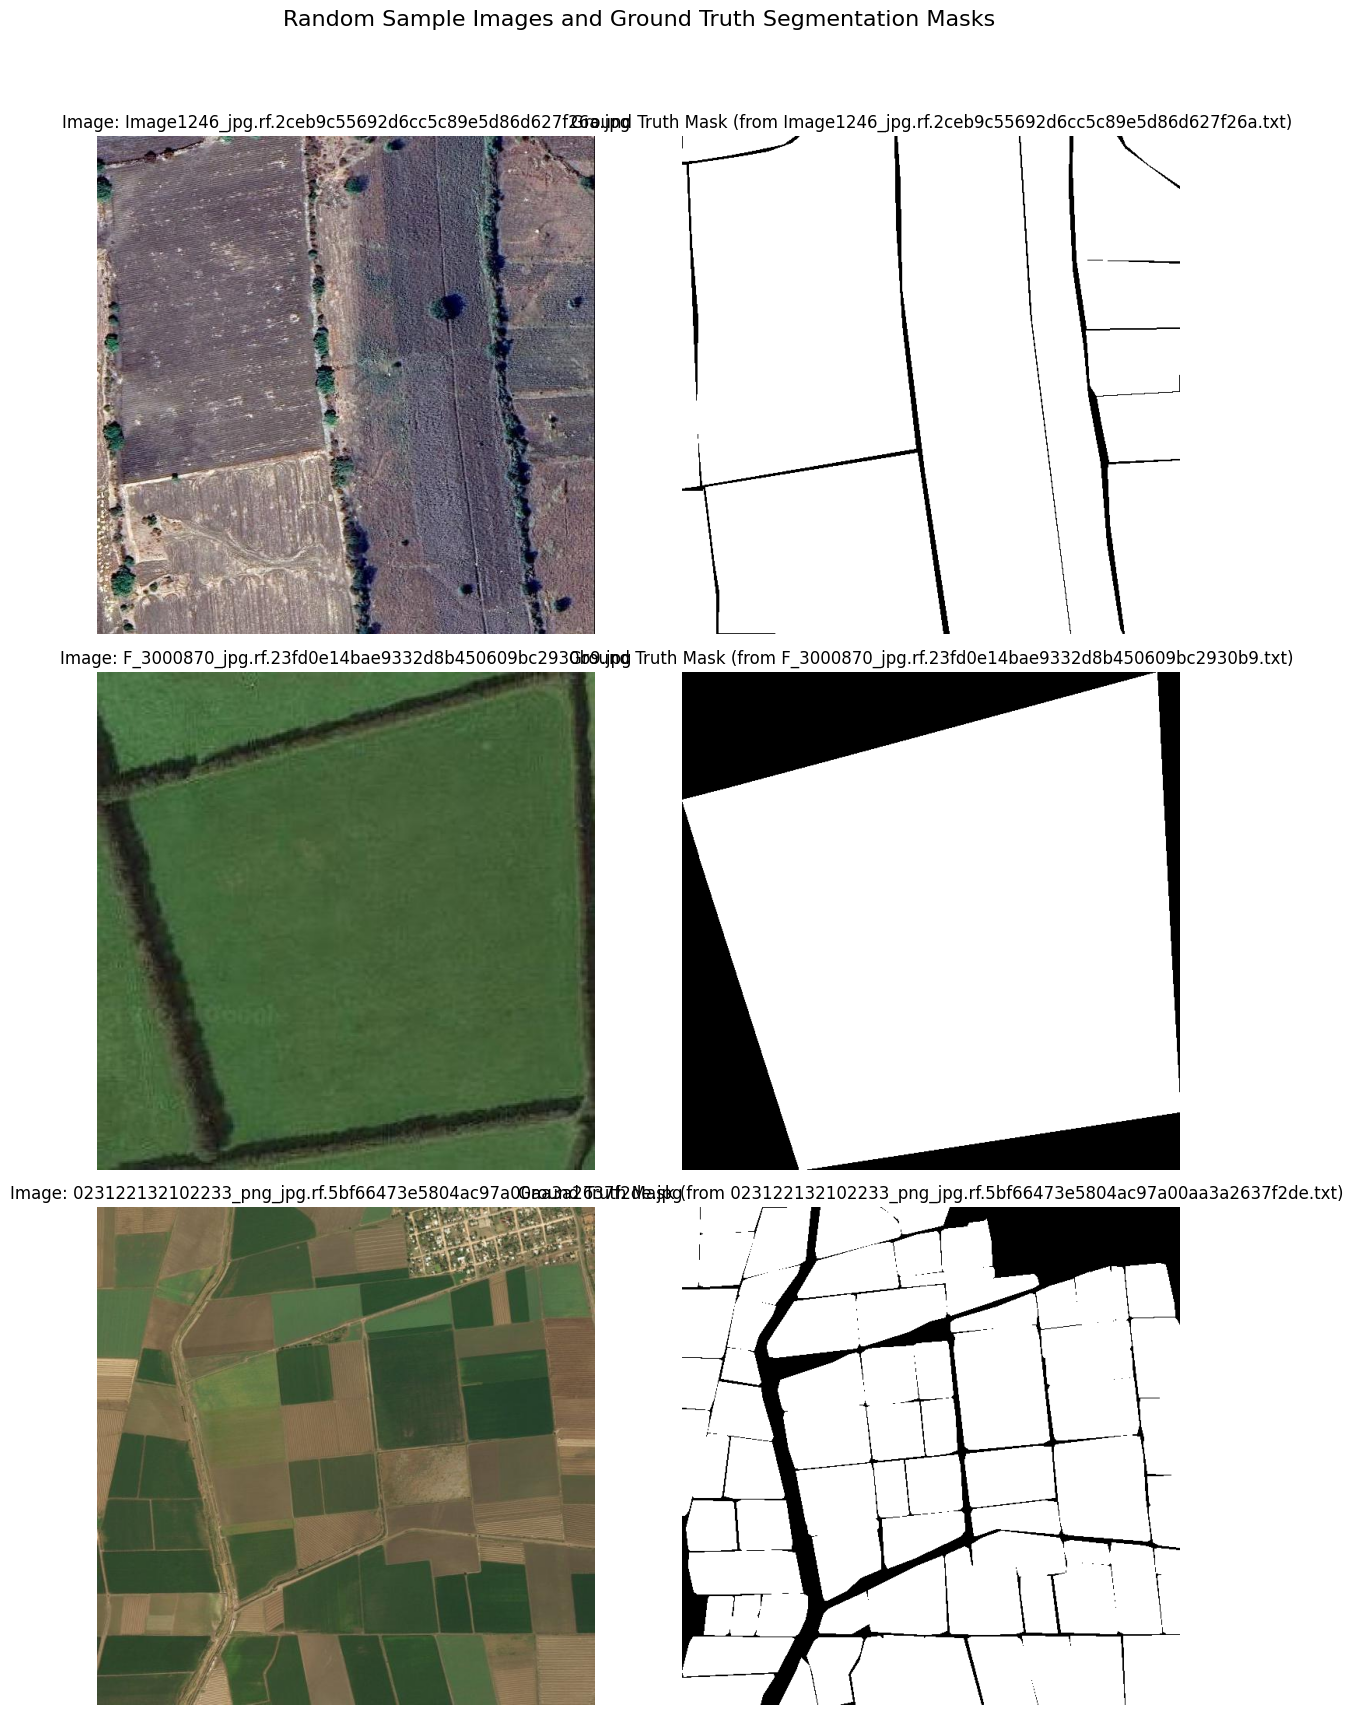

--- Finished Random Sample Visualization ---


In [ ]:
# Visualization function remains largely the same, as it reads YOLO format files
import yaml
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import os

def visualize_yolo_segmentation_samples(data_dir, num_samples=3):
    """Visualizes original images and segmentation masks from YOLOv8 format annotations."""
    print(f"\n--- Starting Random Sample Visualization ({num_samples} samples) ---")

    if not data_dir or not os.path.isdir(data_dir):
        print(f"Error: Invalid data directory: {data_dir}")
        return

    train_img_dir = os.path.join(data_dir, 'train', 'images')
    train_label_dir = os.path.join(data_dir, 'train', 'labels')

    if not os.path.isdir(train_img_dir):
        print(f"Error: Train image directory not found: {train_img_dir}")
        return
    if not os.path.isdir(train_label_dir):
        print(f"Error: Train label directory not found: {train_label_dir}")
        return

    img_files_all = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not img_files_all:
        print(f"No image files found in {train_img_dir}")
        return

    num_available = len(img_files_all)
    num_samples = min(num_samples, num_available)
    if num_samples == 0:
        print("No samples requested or available.")
        return
    img_files = random.sample(img_files_all, num_samples)

    yaml_path = os.path.join(data_dir, 'data.yaml')
    class_names = ['Unknown']
    if os.path.exists(yaml_path):
        try:
            with open(yaml_path, 'r') as f:
                data_yaml = yaml.safe_load(f)
            if 'names' in data_yaml:
                class_names = data_yaml['names']
        except Exception as e:
            print(f"Warning: Error reading class names from data.yaml: {e}")
    else:
        print(f"Warning: data.yaml not found at {yaml_path}.")

    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples))
    if num_samples == 1:
        axes = np.array([axes]) # Ensure axes is always 2D
    fig.suptitle("Random Sample Images and Ground Truth Segmentation Masks", fontsize=16)

    for i, img_file in enumerate(img_files):
        ax_img, ax_mask = axes[i]
        img_path = os.path.join(train_img_dir, img_file)
        try:
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img)
            img_height, img_width = img_np.shape[:2]
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            ax_img.set_title(f"Error loading {img_file}")
            ax_img.axis('off')
            ax_mask.set_title("Mask N/A")
            ax_mask.axis('off')
            continue

        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(train_label_dir, label_file)
        segmentation_mask = np.zeros((img_height, img_width), dtype=np.uint8)

        ax_img.imshow(img_np)
        ax_img.set_title(f"Image: {img_file}")
        ax_img.axis('off')

        if os.path.exists(label_path):
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                for line_idx, line in enumerate(lines):
                    parts = line.strip().split(' ')
                    if len(parts) < 5: continue # Need at least class + 2 points for segmentation
                    class_id = int(parts[0])
                    # Assuming polygon format: class x1 y1 x2 y2 ...
                    if len(parts) % 2 == 1:
                        polygon_points_normalized = []
                        for j in range(1, len(parts), 2):
                            if j + 1 < len(parts):
                                try:
                                    x_norm = float(parts[j])
                                    y_norm = float(parts[j+1])
                                    polygon_points_normalized.append((x_norm, y_norm))
                                except ValueError:
                                    print(f"Warning: Invalid coordinate in {label_file}, line {line_idx+1}")
                                    polygon_points_normalized = [] # Reset for this line
                                    break
                        if len(polygon_points_normalized) >= 3:
                            polygon_points_pixels = [(int(x*img_width), int(y*img_height)) for x,y in polygon_points_normalized]
                            pts = np.array(polygon_points_pixels, np.int32).reshape((-1, 1, 2))
                            cv2.fillPoly(segmentation_mask, [pts], 255) # Fill mask white
            except Exception as e:
                print(f"Error processing label file {label_file}: {e}")
                ax_mask.set_title("Error reading labels")
        else:
            ax_mask.set_title("Label file missing")

        ax_mask.imshow(segmentation_mask, cmap='gray')
        ax_mask.set_title(f"Ground Truth Mask (from {label_file})")
        ax_mask.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("--- Finished Random Sample Visualization ---")

# Run the visualization
if dataset_location:
    try:
        num_visual_samples = 3
        visualize_yolo_segmentation_samples(dataset_location, num_samples=num_visual_samples)
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"An unexpected error occurred during visualization: {e}")
else:
    print("\nError: Dataset location not defined. Cannot run visualization.")

### 2.4 Data Preparation

The data downloaded from Roboflow in YOLOv8 format is already structured correctly for YOLOv8 training. It expects a specific directory structure (`train/images`, `train/labels`, `valid/images`, `valid/labels`) and a `data.yaml` file defining the paths and class names.

We just need to ensure the `data.yaml` path is correctly identified.

In [ ]:
# Verify the data.yaml path again and print its contents
if data_yaml_path and os.path.exists(data_yaml_path):
    print(f"Using data configuration file: {data_yaml_path}")
    try:
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
        print("\nContents of data.yaml:")
        print(yaml.dump(data_config))
        
        # Optional: Check if paths in data.yaml are relative/absolute and adjust if needed
        # This might be necessary if the YAML paths are incorrect relative to the notebook's execution location
        # Example check (adjust logic as needed):
        # if not os.path.isabs(data_config['train']):
        #    data_config['train'] = os.path.join(dataset_location, data_config['train'])
        #    data_config['val'] = os.path.join(dataset_location, data_config['val'])
        #    print("\nAdjusted paths in data_config to be absolute (if necessary).")
        
    except Exception as e:
        print(f"Error reading or parsing data.yaml: {e}")
        data_yaml_path = None # Mark as invalid
else:
    print("ERROR: data.yaml path is not valid or file doesn't exist.")
    print("YOLOv8 training cannot proceed without a valid data.yaml file.")
    # You might need to manually create or correct the data.yaml file here
    # It should look something like this:
    # train: ../train/images
    # val: ../valid/images
    # 
    # nc: 1  # number of classes
    # names: ['farm'] # class names

Using data configuration file: /kaggle/working/Final-Detectron-2-1/data.yaml

Contents of data.yaml:
names:
- Farms
nc: 1
roboflow:
  license: MIT
  project: final-detectron-2
  url: https://universe.roboflow.com/sid-mp92l/final-detectron-2/dataset/1
  version: 1
  workspace: sid-mp92l
test: ../test/images
train: ../train/images
val: ../valid/images



*(Removed Custom Dataset and DataLoader setup as YOLOv8 handles data loading internally based on `data.yaml`)*

## 3. Modeling with YOLOv8

### 3.1 Transfer Learning with Pre-trained YOLOv8

We will use a pre-trained YOLOv8 segmentation model (`yolov8n-seg.pt`) as a starting point. This leverages knowledge learned from a large dataset (COCO) and allows for faster convergence and better performance on our specific farmland segmentation task. This process is known as **transfer learning** or **fine-tuning**.

In [ ]:
# Load a pre-trained YOLOv8 segmentation model
try:
    # Choose a model size (n, s, m, l, x) - 'n' is smallest and fastest
    model_name = 'yolov8n-seg.pt'
    model = YOLO(model_name)
    print(f"Successfully loaded pre-trained model: {model_name}")
    
    # Move model to the appropriate device (handled internally by YOLO, but good to confirm)
    # model.to(device) # YOLO handles device assignment during train/val/predict
    print(f"Model will use device(s): {device} during operations")
    
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    print("Ensure 'ultralytics' is installed and the model name is correct.")
    model = None

Successfully loaded pre-trained model: yolov8n-seg.pt
Model will use device(s): 0,1 during operations


**Note:** Yes, the model loaded (`yolov8n-seg.pt`) is specifically a **segmentation** model provided by Ultralytics. It predicts both bounding boxes and pixel-level masks for detected objects.

### 3.2 Training / Fine-tuning the Model

We will now train (fine-tune) the pre-trained YOLOv8 model on our custom farmland dataset using the configuration specified in `data.yaml`.

In [ ]:
# Training configuration
num_epochs = 50  # Start with a reasonable number, can be adjusted
image_size = 640 # YOLOv8 default, adjust if needed
batch_size = 16  # Adjust based on GPU memory ('auto' lets YOLO decide)
project_name = 'FarmWise_YOLOv8_Segmentation'
run_name = 'initial_finetune'

if model and data_yaml_path:
    print("\nStarting YOLOv8 training...")
    print("The output below will show progress per epoch, including:")
    print("- Epoch number")
    print("- Losses (box, segmentation, classification)")
    print("- Key metrics (e.g., mAP50, mAP50-95 for segmentation)")
    print("- Time per epoch")
    print("- Estimated time remaining (ETA)")
    try:
        # Train the model
        # verbose=True (default) provides detailed epoch-by-epoch updates including metrics and ETA.
        results = model.train(
            data=data_yaml_path, 
            epochs=num_epochs, 
            imgsz=image_size, 
            batch=batch_size, 
            device=device, # Pass the potentially multi-GPU device string
            project=project_name, # Directory to save results
            name=run_name, # Subdirectory for this specific run
            exist_ok=True, # Allow overwriting previous runs with the same name
            patience=10, # Early stopping patience
            verbose=True, # Show detailed training progress (includes stats, metrics, ETA per epoch)
            optimizer='AdamW', # Use AdamW optimizer for better performance
            lr0=0.001, # Initial learning rate
            weight_decay=0.0005, # Add weight decay (adjust value as needed)
            # Add other hyperparameters here if needed, e.g., optimizer='AdamW', lr0=0.001
        )
        print("\nTraining completed.")
        print(f"Results, logs, plots, and model weights saved to: {results.save_dir}")
        # The best model checkpoint is usually saved as 'best.pt' in the run directory's weights folder
        best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
        if os.path.exists(best_model_path):
             print(f"Best model saved at: {best_model_path}")
        else:
             print(f"Could not find 'best.pt' in {os.path.join(results.save_dir, 'weights')}. Check training output.")
             # Fallback: try finding last.pt
             last_model_path = os.path.join(results.save_dir, 'weights', 'last.pt')
             if os.path.exists(last_model_path):
                 print(f"Using last model checkpoint: {last_model_path}")
                 best_model_path = last_model_path
             else:
                 best_model_path = None
        
    except Exception as e:
        print(f"\nAn error occurred during YOLOv8 training: {e}")
        import traceback
        traceback.print_exc()
        best_model_path = None
else:
    print("\nSkipping training: Model or data.yaml path not available.")
    best_model_path = None


Starting YOLOv8 training...
The output below will show progress per epoch, including:
- Epoch number
- Losses (box, segmentation, classification)
- Key metrics (e.g., mAP50, mAP50-95 for segmentation)
- Time per epoch
- Estimated time remaining (ETA)
Ultralytics 8.3.109 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/kaggle/working/Final-Detectron-2-1/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0,1, workers=8, project=FarmWise_YOLOv8_Segmentation, name=initial_finetune, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, va

100%|██████████| 755k/755k [00:00<00:00, 4.12MB/s]



Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytic

KeyboardInterrupt: 

### Training Output and Results

The cell above displays the training progress live. For each epoch, you should see:
*   Loss values (box, segmentation, classification)
*   Segmentation metrics (mAP50, mAP50-95)
*   Time taken for the epoch and estimated time remaining (ETA).

All detailed results, including metrics plots (like loss curves, PR curves), confusion matrices, and saved model checkpoints (`best.pt`, `last.pt`), are stored in the directory printed at the end of the training output (e.g., `FarmWise_YOLOv8_Segmentation/initial_finetune/`). You can inspect these files for a comprehensive analysis after training completes.

### 3.3 Hyperparameter Tuning (Advanced)

YOLOv8 offers capabilities for hyperparameter tuning using genetic algorithms to potentially improve performance further. This is an advanced step usually performed after initial training.

The `model.tune()` method can be used, but requires careful setup and significant computational resources. It explores different combinations of learning rates, weight decay, augmentation parameters, etc.

**Example Concept (Consult Ultralytics Docs for Details):**
```python
# # --- Example placeholder for tuning ---
# # This requires significant time and compute.
# if model and data_yaml_path and best_model_path:
#     print("\nStarting Hyperparameter Tuning (this may take a long time)...")
#     try:
#         # Load the best model from the initial training run
#         tuned_model = YOLO(best_model_path)
#         
#         # Run tuning
#         tuned_model.tune(
#             data=data_yaml_path,
#             epochs=30, # Tuning epochs (can be fewer than full training)
#             iterations=100, # Number of tuning iterations
#             optimizer='AdamW', 
#             project=project_name,
#             name='hyperparameter_tuning',
#             plots=False, 
#             save=False, 
#             val=False,
#             device=device
#         )
#         print("\nTuning finished. Best hyperparameters saved.")
#         # The best hyperparameters are typically saved to a yaml file.
#         # You would then retrain using these hyperparameters.
#     except Exception as e:
#         print(f"\nError during hyperparameter tuning: {e}")
# else:
#     print("\nSkipping hyperparameter tuning: Prerequisite model or data not available.")
```
Refer to the [Ultralytics documentation](https://docs.ultralytics.com/modes/tune/) for detailed guidance on hyperparameter tuning.

## 4. Model Evaluation and Visualization

Let's load our best fine-tuned model and evaluate its performance on the validation set using YOLOv8's built-in methods.

In [ ]:
# Load the best model for evaluation
initial_map50_95 = None # Store initial metrics
initial_map50 = None
visualization_sample_images = [] # Store sample images for later comparison

if 'best_model_path' not in locals(): # Define if training was skipped
    # Attempt to manually define the path if needed, e.g. from a previous run
    potential_path = os.path.join(project_name, run_name, 'weights', 'best.pt')
    if os.path.exists(potential_path):
        best_model_path = potential_path
        print(f"Manually identified best model path: {best_model_path}")
    else:
        best_model_path = None
        print("best_model_path variable not found. Please ensure training ran or set the path manually.")

if best_model_path and os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    try:
        eval_model = YOLO(best_model_path)
        print("Best model loaded successfully for evaluation.")
    except Exception as e:
        print(f"Error loading best model: {e}")
        eval_model = None
elif 'model' in locals() and model is not None: # Fallback to the model after initial loading if best.pt wasn't identified/trained
    print("Warning: Best model path not found or invalid. Using initially loaded pre-trained model for evaluation structure.")
    eval_model = model 
else:
    print("Error: No model available for evaluation.")
    eval_model = None

# --- Evaluate the Model ---
if eval_model and data_yaml_path:
    print("\nRunning validation on the loaded model...")
    try:
        metrics = eval_model.val(
            data=data_yaml_path,
            imgsz=image_size,
            batch=batch_size,
            split='val', # Specify the split to evaluate (usually 'val' or 'test')
            device=device, # Pass the potentially multi-GPU device string
            project=project_name,
            name=f'{run_name}_validation', # Save validation results separately
            exist_ok=True
        )
        print("\nValidation complete.")
        print("Initial Model Segmentation Metrics:")
        # Access specific metrics (keys might vary slightly based on YOLO version)
        # Common metrics for segmentation include mAP50-95(M) and mAP50(M)
        initial_map50_95 = metrics.seg.map  # Store for comparison
        initial_map50 = metrics.seg.map50 # Store for comparison
        print(f"  mAP50-95 (Mask): {initial_map50_95:.4f}")
        print(f"  mAP50 (Mask):    {initial_map50:.4f}")
        # Check against success criteria (adjust metric as needed)
        target_map = 0.6 # Example target mAP50-95
        if initial_map50_95 > target_map:
             print(f"\n✅ Success! Achieved target mAP50-95 > {target_map} (Actual: {initial_map50_95:.4f})")
        else:
             print(f"\n❌ Target mAP50-95 > {target_map} not achieved (Actual: {initial_map50_95:.4f})")
             
    except AttributeError:
        print("\nCould not access segmentation metrics (e.g., metrics.seg.map). This might happen if:")
        print("  - The loaded model is not a segmentation model.")
        print("  - Validation failed to produce segmentation results.")
        print("  - The Ultralytics API version has changed metric accessors.")
        print("  Check the 'metrics' object structure or validation logs.")
        # print(metrics) # Uncomment to inspect the metrics object
    except Exception as e:
        print(f"\nAn error occurred during validation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nSkipping evaluation: Model or data.yaml path not available.")

# --- Visualize Predictions ---
if eval_model and dataset_location:
    print("\nVisualizing predictions on validation images...")
    val_img_dir = os.path.join(dataset_location, 'valid', 'images')
    if os.path.isdir(val_img_dir):
        val_images = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_viz_samples = min(5, len(val_images))
        if num_viz_samples > 0:
            # Store the sampled images for later use with the re-trained model
            visualization_sample_images = random.sample(val_images, num_viz_samples)
            print(f"Selected {len(visualization_sample_images)} images for visualization comparison.")
            try:
                # Run prediction
                pred_results = eval_model.predict(
                    source=visualization_sample_images, # Use the stored list
                    save=False, # Don't save individual prediction images by default
                    show=False, # Don't display using cv2.imshow
                    conf=0.5, # Confidence threshold for predictions
                    device=device # Pass the potentially multi-GPU device string
                )
                
                # Plot results using matplotlib
                print(f"Displaying {len(pred_results)} prediction results (Initial Model):")
                for i, r in enumerate(pred_results):
                    im_bgr = r.plot()  # BGR numpy array of predictions
                    im_rgb = Image.fromarray(im_bgr[..., ::-1]) # Convert BGR to RGB
                    
                    plt.figure(figsize=(10, 10))
                    plt.imshow(im_rgb)
                    plt.title(f"Initial Model Prediction: {os.path.basename(visualization_sample_images[i])}")
                    plt.axis('off')
                    plt.show()
                    
                # You can also access raw results:
                # print(f"\nDetails for {os.path.basename(visualization_sample_images[i])}:")
                # print(f"  Detected boxes: {len(r.boxes)}")
                # if r.masks:
                #    print(f"  Detected masks: {len(r.masks)}")
                #    # Access mask data: r.masks.data, r.masks.xy
                
            except Exception as e:
                print(f"\nError during prediction or visualization: {e}")
                traceback.print_exc()
        else:
            print("No validation images found to visualize.")
    else:
        print(f"Validation image directory not found: {val_img_dir}")
else:
    print("\nSkipping prediction visualization: Model or dataset location not available.")

## 5. Post-processing: Farm Size Calculation and Classification

After segmenting the farms using the trained YOLOv8 model, we need to process the predicted masks to calculate the area of each farm and classify them based on size.

In [ ]:
from skimage import measure
import numpy as np

def calculate_farm_properties(predictions, confidence_threshold=0.5, min_area_pixels=100):
    """
    Processes YOLOv8 prediction results to find farms, calculate their areas,
    and classify their size.
    
    Args:
        predictions: List of result objects from model.predict().
        confidence_threshold (float): Minimum confidence for a detection.
        min_area_pixels (int): Minimum pixel area to consider a segment a farm.
        
    Returns:
        List of dictionaries, each containing info for one image:
        {'image_path': str, 'farms': [{'id': int, 'area_pixels': float, 'size_category': str, 'confidence': float, 'bbox': list}]}
    """
    results_list = []
    farm_class_index = 0 # Assuming 'farm' is the first class (index 0) in data.yaml. Adjust if necessary.
    
    print(f"Processing {len(predictions)} prediction results...")
    
    for i, result in enumerate(predictions):
        image_path = result.path
        image_farms = []
        img_h, img_w = result.orig_shape # Original image dimensions
        
        if result.masks is None or result.boxes is None:
            # print(f"No masks or boxes found for {os.path.basename(image_path)}")
            results_list.append({'image_path': os.path.basename(image_path), 'farms': []})
            continue
            
        masks = result.masks.data.cpu().numpy() # (N, H, W) tensor of masks
        boxes = result.boxes.data.cpu().numpy() # (N, 6) tensor [x1, y1, x2, y2, conf, cls]
        
        # print(f"Processing {os.path.basename(image_path)}: Found {len(boxes)} detections.")
        
        farm_id_counter = 0
        for j in range(len(boxes)):
            confidence = boxes[j, 4]
            class_id = int(boxes[j, 5])
            
            # Filter by confidence and class (assuming farm is class 0)
            if confidence >= confidence_threshold and class_id == farm_class_index:
                mask = masks[j]
                # Resize mask to original image size if necessary (YOLO might predict on resized)
                if mask.shape[0] != img_h or mask.shape[1] != img_w:
                     mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
                     
                # Calculate area (number of positive pixels in the mask)
                area_pixels = np.sum(mask > 0.5) # Use 0.5 threshold on mask probabilities
                
                if area_pixels >= min_area_pixels:
                    farm_id_counter += 1
                    bbox_xyxy = boxes[j, :4].tolist() # [x1, y1, x2, y2]
                    
                    # --- Size Classification (Example thresholds - adjust based on needs) ---
                    if area_pixels < 5000:
                        size_category = 'Small'
                    elif area_pixels < 20000:
                        size_category = 'Medium'
                    else:
                        size_category = 'Large'
                        
                    image_farms.append({
                        'id': farm_id_counter,
                        'area_pixels': area_pixels,
                        'size_category': size_category,
                        'confidence': float(confidence),
                        'bbox': bbox_xyxy
                    })
                    # print(f"  Farm {farm_id_counter}: Area={area_pixels}px, Class={size_category}, Conf={confidence:.2f}")
                # else:
                    # print(f"  Skipping detection {j}: Area {area_pixels}px < {min_area_pixels}px")
            # else:
                # print(f"  Skipping detection {j}: Conf {confidence:.2f} or Class {class_id} != {farm_class_index}")
                
        results_list.append({'image_path': os.path.basename(image_path), 'farms': image_farms})
        # Optional: Reduce verbosity during post-processing
        # if not image_farms:
        #      print(f"No farms meeting criteria found in {os.path.basename(image_path)}")
        # else:
        #      print(f"Found {len(image_farms)} farms in {os.path.basename(image_path)}")
             
    return results_list

# --- Run Post-processing on the visualized predictions ---
# Ensure pred_results exists from the visualization cell
if 'pred_results' in locals() and pred_results:
    print("\nCalculating farm sizes and categories for visualized samples...")
    farm_data = calculate_farm_properties(pred_results, confidence_threshold=0.5, min_area_pixels=500)
    
    # Display calculated data
    import json
    print("\n--- Farm Size Calculation Results ---")
    for img_result in farm_data:
        print(f"Image: {img_result['image_path']}")
        if img_result['farms']:
            for farm in img_result['farms']:
                print(f"  - Farm ID: {farm['id']}, Area: {farm['area_pixels']:.0f} pixels, Category: {farm['size_category']}, Confidence: {farm['confidence']:.2f}")
        else:
            print("  No farms detected or meeting criteria.")
        print("---")
else:
    print("\nSkipping farm size calculation: No prediction results available from the previous cell.")
    print("Ensure the 'Visualize Predictions' part of the evaluation cell ran successfully.")

## 6. Continued Fine-tuning (Transfer Learning from Fine-tuned Model)

Based on the evaluation results, we might want to continue training the model for more epochs or with adjusted hyperparameters (like a lower learning rate) starting from the best checkpoint achieved in the previous training run (`best.pt`). This allows the model to potentially refine its weights further on the specific dataset.

In [ ]:
# --- Continued Fine-tuning ---

# Ensure the path to the best model from the *previous* run is available
# This path was determined in the evaluation cell (cell ID b4df7607)
if 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    print(f"Loading model for continued fine-tuning from: {best_model_path}")
    try:
        # Load the previously fine-tuned model
        continued_model = YOLO(best_model_path)
        print("Model loaded successfully.")
        
        # Define parameters for the continued training run
        continued_epochs = 25 # Number of *additional* epochs
        continued_run_name = 'continued_finetune'
        # Optional: Adjust learning rate (often lower for continued tuning)
        # initial_lr = 0.0005 # Example: Lower learning rate
        
        print(f"\nStarting continued fine-tuning for {continued_epochs} additional epochs...")
        
        # Train again, starting from the loaded weights
        continued_results = continued_model.train(
            data=data_yaml_path, 
            epochs=num_epochs + continued_epochs, # Total epochs = original + additional
            imgsz=image_size, 
            batch=batch_size, 
            device=device, 
            project=project_name, 
            name=continued_run_name, # Save to a new run directory
            exist_ok=True, 
            patience=10, 
            verbose=True,
            resume=False # Start training from the loaded weights, don't resume an interrupted run
            # You might pass adjusted hyperparameters here:
            # lr0=initial_lr, # Example: Set initial learning rate
            optimizer='AdamW', # Example: Specify optimizer
        )
        
        print("\nContinued fine-tuning completed.")
        print(f"Results saved to: {continued_results.save_dir}")
        # Update best_model_path to the newly trained best model if needed for subsequent steps
        new_best_model_path = os.path.join(continued_results.save_dir, 'weights', 'best.pt')
        if os.path.exists(new_best_model_path):
             print(f"New best model saved at: {new_best_model_path}")
             best_model_path = new_best_model_path # Update for potential further use
             # Store the path specifically for the continued model
             continued_best_model_path = new_best_model_path 
        else:
             print(f"Could not find 'best.pt' in {os.path.join(continued_results.save_dir, 'weights')}. Check training output.")
             continued_best_model_path = None # Indicate failure
             
    except Exception as e:
        print(f"\nAn error occurred during continued fine-tuning: {e}")
        import traceback
        traceback.print_exc()
        continued_best_model_path = None
        
elif not data_yaml_path:
     print("\nSkipping continued fine-tuning: data.yaml path not available.")
     continued_best_model_path = None
else:
    print("\nSkipping continued fine-tuning: 'best_model_path' from the previous run is not defined or the file does not exist.")
    print("Please ensure the initial training and evaluation steps completed successfully and 'best.pt' was saved.")
    continued_best_model_path = None

## 7. Evaluation and Comparison of Re-trained Model

Now, let's evaluate the model that underwent continued fine-tuning and compare its performance metrics and prediction visualizations against the initial fine-tuned model.

In [ ]:
# --- Evaluate the Re-trained Model ---
continued_map50_95 = None
continued_map50 = None

# Check if the continued training produced a best model path
if 'continued_best_model_path' in locals() and continued_best_model_path and os.path.exists(continued_best_model_path):
    print(f"Loading re-trained model from: {continued_best_model_path}")
    try:
        retrained_eval_model = YOLO(continued_best_model_path)
        print("Re-trained model loaded successfully for evaluation.")
        
        if data_yaml_path:
            print("\nRunning validation on the re-trained model...")
            retrained_metrics = retrained_eval_model.val(
                data=data_yaml_path,
                imgsz=image_size,
                batch=batch_size,
                split='val',
                device=device,
                project=project_name,
                name=f'{continued_run_name}_validation', # Save to a new validation folder
                exist_ok=True
            )
            print("\nRe-trained Model Validation complete.")
            print("Re-trained Model Segmentation Metrics:")
            continued_map50_95 = retrained_metrics.seg.map
            continued_map50 = retrained_metrics.seg.map50
            print(f"  mAP50-95 (Mask): {continued_map50_95:.4f}")
            print(f"  mAP50 (Mask):    {continued_map50:.4f}")
        else:
            print("Skipping re-trained model validation: data.yaml path not available.")
            retrained_eval_model = None # Cannot evaluate
            
    except Exception as e:
        print(f"Error loading or validating re-trained model: {e}")
        retrained_eval_model = None
else:
    print("Skipping re-trained model evaluation: Path 'continued_best_model_path' not found or invalid.")
    retrained_eval_model = None

# --- Compare Metrics ---
print("\n--- Metrics Comparison ---")
if initial_map50_95 is not None and continued_map50_95 is not None:
    print(f"                     Initial Model | Re-trained Model")
    print(f"mAP50-95 (Mask):      {initial_map50_95:^13.4f} | {continued_map50_95:^16.4f}")
    print(f"mAP50 (Mask):         {initial_map50:^13.4f} | {continued_map50:^16.4f}")
    delta_map50_95 = continued_map50_95 - initial_map50_95
    delta_map50 = continued_map50 - initial_map50
    print(f"Delta (Re-trained - Initial):")
    print(f"  Δ mAP50-95: {delta_map50_95:+.4f}")
    print(f"  Δ mAP50:    {delta_map50:+.4f}")
else:
    print("Could not compare metrics. Ensure both initial and continued evaluations ran successfully.")

In [ ]:
# --- Visualize Re-trained Model Predictions (on the same images) ---
if 'retrained_eval_model' in locals() and retrained_eval_model and 'visualization_sample_images' in locals() and visualization_sample_images:
    print("\nVisualizing predictions from re-trained model on the same sample images...")
    try:
        # Run prediction with the re-trained model
        retrained_pred_results = retrained_eval_model.predict(
            source=visualization_sample_images, # Use the SAME images stored earlier
            save=False,
            show=False,
            conf=0.5, 
            device=device
        )
        
        # Plot results using matplotlib
        print(f"Displaying {len(retrained_pred_results)} prediction results (Re-trained Model):")
        for i, r in enumerate(retrained_pred_results):
            im_bgr = r.plot()  
            im_rgb = Image.fromarray(im_bgr[..., ::-1])
            
            plt.figure(figsize=(10, 10))
            plt.imshow(im_rgb)
            plt.title(f"Re-trained Model Prediction: {os.path.basename(visualization_sample_images[i])}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"\nError during re-trained model prediction or visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nSkipping re-trained prediction visualization: Re-trained model or sample image list not available.")

## 8. Comparison Summary

Review the metrics comparison table and the side-by-side visualizations above.

*   **Metrics**: Did the mAP scores improve after continued fine-tuning? A positive delta indicates improvement.
*   **Visualizations**: Compare the segmentation masks produced by the initial model and the re-trained model for the same images. Look for:
    *   More accurate boundaries around farms.
    *   Fewer false positives (incorrectly identified areas).
    *   Fewer false negatives (missed farms).
    *   Better separation of adjacent farms.

Based on this comparison, decide if the continued fine-tuning was beneficial and if further training or hyperparameter adjustments are needed.